# Imports

In [93]:
!pip install fiftyone

In [94]:
import os
import numpy as np
import transformers
import fiftyone
from PIL import Image
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from typing import Tuple, List


In [95]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Data

In [96]:
dataset = fiftyone.zoo.load_zoo_dataset(
    "open-images-v7",
    split="test",
    max_samples=50,
)

Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading 'open-images-v7' split 'test'
 100% |███████████████████| 50/50 [3.1s elapsed, 0s remaining, 20.5 samples/s]      
Dataset 'open-images-v7-test-50' created


In [97]:
session = fiftyone.launch_app(dataset)

Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [98]:
dataset

Name:        open-images-v7-test-50
Media type:  image
Num samples: 50
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    detections:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    points:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Keypoints)
    segmentations:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    relationships:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.De

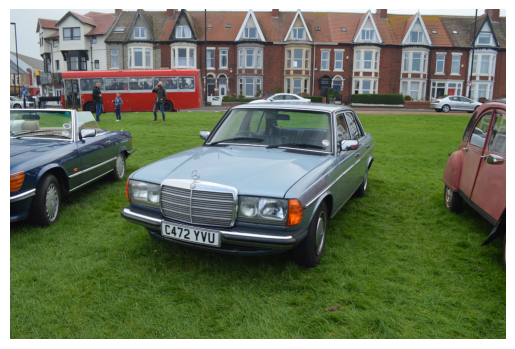

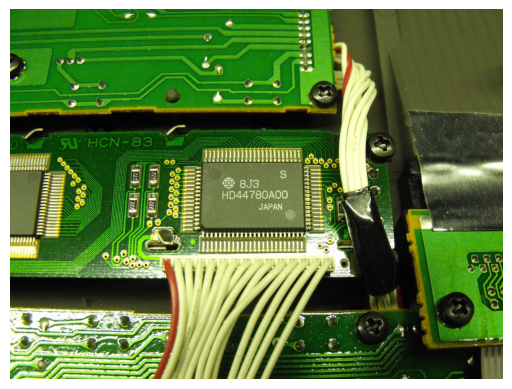

In [99]:
samples = dataset.take(2)

for sample in samples:
    image = Image.open(sample.filepath)
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

In [100]:
filepaths = dataset.values("filepath")

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


tf_dataset = tf.data.Dataset.from_tensor_slices(filepaths)
tf_dataset = tf_dataset.map(load_and_preprocess_image)

Show images from tf_dataset

In [101]:
def show_image(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()


# Function to display images in a grid
def show_images(images: list):
    plt.figure(figsize=(15, 15))

    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [102]:
class RandomGrayscale(tf.keras.layers.Layer):
    def __init__(self, probability=0.1, **kwargs):
        super(RandomGrayscale, self).__init__(**kwargs)
        self.probability = probability

    def call(self, inputs, training=None, **kwargs):
        def apply_grayscale():
            grayscale_image = tf.image.rgb_to_grayscale(inputs)
            return tf.image.grayscale_to_rgb(grayscale_image)

        random_numbers = tf.random.uniform([], minval=0, maxval=1)
        should_apply_grayscale = random_numbers < self.probability
        output = tf.cond(should_apply_grayscale, apply_grayscale, lambda: inputs)
        return output


    def get_config(self):
        config = super(RandomGrayscale, self).get_config()
        config.update({'probability': self.probability})
        return config

In [113]:
class DataAugmentationDINO:
    def __init__(self, global_crops_scale, local_crops_scale, global_crops_number = 2, local_crops_number = 4):
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.global_crops_number = global_crops_number
        self.local_crops_number = local_crops_number

        self.flip_and_color_jitter = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomContrast(factor=0.25),
            tf.keras.layers.RandomBrightness(factor=0.3),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.GaussianNoise(stddev=0.1),
            RandomGrayscale(probability=0.2),

            tf.keras.layers.Rescaling(scale=1. / 255)
        ])

    def __call__(self, image) -> Tuple[List[Image], List[Image]]:
        global_crops = []
        for _ in range(self.local_crops_number):
            global_crop = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
            global_crop = self.flip_and_color_jitter(global_crop)
            global_crops.append(global_crop)

        local_crops = []
        for _ in range(self.local_crops_number):
            local_crop = self._random_resized_crop(image, size=96, scale=self.local_crops_scale)
            local_crop = self.flip_and_color_jitter(local_crop)
            local_crops.append(local_crop)

        return global_crops, local_crops

    @staticmethod
    def _random_resized_crop(image, size, scale):
        height, width = tf.shape(image)[0].numpy(), tf.shape(image)[1].numpy()
        crop_height = tf.random.uniform(shape=[], minval=tf.cast((height * scale[0]), tf.int32),
                                        maxval=tf.cast((height * scale[1]), tf.int32), dtype=tf.dtypes.int32)
        crop_width = tf.random.uniform(shape=[], minval=tf.cast((width * scale[0]), tf.int32),
                                       maxval=tf.cast((width * scale[1]), tf.int32), dtype=tf.dtypes.int32)

        cropped_image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
        resized_image = tf.image.resize(cropped_image, [size, size])

        return resized_image


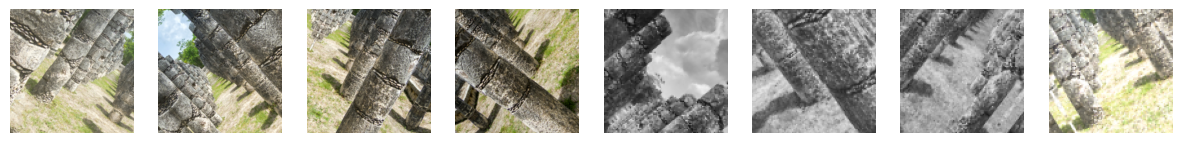

In [114]:
aug = DataAugmentationDINO((0.5, 0.6), (0.25, 0.5), 2, 4)
image = next(iter(tf_dataset))
global_crops, local_crops = aug(image)
show_images(global_crops + local_crops)

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

In [115]:
# def dino_loss(student_output, teacher_output, temperature=0.1):
#     """
#     DINO loss function.
#     student_output: logits from the student network
#     teacher_output: logits from the teacher network (detached from gradients)
#     temperature: temperature scaling for the softmax function
#     """
#     student_probs = tf.nn.softmax(student_output / temperature, axis=-1)
#     teacher_probs = tf.nn.softmax(teacher_output / temperature, axis=-1)
#     loss = tf.reduce_mean(tf.keras.losses.kullback_leibler_divergence(teacher_probs, student_probs))
#     return loss

# Backbone

Implement a transformer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

In [116]:
class DinoLoss(tf.keras.losses.Loss):
    def __init__(
            self,
            out_dim,
            teacher_temp,
            student_temp=0.1,
            center_momentum=0.9
    ):
        super().__init__()
        self.center = tf.Variable(tf.zeros(out_dim), trainable=False)
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum

    def call(self, teacher_output, student_output):
        teacher_out = tf.nn.l2_normalize(teacher_output - self.center, -1)
        student_out = tf.nn.l2_normalize(student_output, -1)
        loss = tf.reduce_mean(tf.reduce_sum(-teacher_out * tf.nn.log_softmax(student_out / self.student_temp, -1), -1))
        self.update_center(teacher_output)
        return loss

    def update_center(self, teacher_output):
        batch_center = tf.reduce_mean(teacher_output, axis=0)
        self.center.assign((self.center * self.center_momentum) + (batch_center * (1 - self.center_momentum)))

In [117]:
class DinoHead(tf.keras.models.Model):
    def __init__(
            self,
            input_dimension,
            out_dim,
            use_batch_normalization=False,
            norm_last_layer=True,
            layers_count=3,
    ):
        super(DinoHead, self).__init__()
    
        self.hidden_dim = 2048
        self.bottleneck_dim = 256
    
        self.input_dimension = input_dimension
        self.use_batch_normalization = use_batch_normalization
        self.out_dim = out_dim
        self.layers_count = layers_count
    
        self.norm_last_layer = norm_last_layer
        self.last_layer = tf.keras.layers.Dense(self.out_dim)
    
        self.mlp_block = self.mlp()
    
    def mlp(self):
        layers = [tf.keras.layers.Dense(self.hidden_dim, input_shape=(self.input_dimension,))]
    
        if self.use_batch_normalization:
            layers.append(tf.keras.layers.BatchNormalization())
    
        for _ in range(self.layers_count - 2):
            layers.append(tf.keras.layers.Dense(self.hidden_dim))
    
        if self.use_batch_normalization:
            layers.append(tf.keras.layers.BatchNormalization())
    
        layers.append(tf.keras.layers.ReLU())
        layers.append(tf.keras.layers.Dense(self.bottleneck_dim))
        return tf.keras.Sequential(layers)
    
    def call(self, input_tensor, mask=None, training=None):
        x = self.mlp_block(input_tensor, training)
        if self.norm_last_layer:
            x = tf.nn.l2_normalize(x, axis=-1)
        x = self.last_layer(x)
        return x

In [118]:
class Dino(tf.keras.Model):
    def __init__(self, teacher, student, loss):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.loss = loss

    def _forward(self, teacher_input, student_input):
        teacher_output = self.teacher(teacher_input, training=False)
        student_output = self.student(student_input, training=True)
        return teacher_output, student_output

    def train_step(self, data):
        teacher_input, student_input = data

        with tf.GradientTape() as tape:
            teacher_output, student_output = self._forward(teacher_input, student_input)
            loss = self.loss(teacher_output, student_output)

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.compiled_metrics.update_state(teacher_output, student_output)

        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, mask=None):
        if training:
            return self.student(inputs, training=True)
        else:
            return self.teacher(inputs, training=False)


In [119]:
class HeadedBackbone(tf.keras.Model):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def call(self, inputs, training=False, mask=None):
        x = self.backbone(inputs, training=training)
        return self.head(x, training=training)

In [120]:
backbone = transformers.TFViTModel.from_pretrained("google/vit-base-patch16-224")
processor = transformers.ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
dino_head = DinoHead(input_dimension=768, out_dim=65536)
dino_loss = DinoLoss(out_dim=65536, teacher_temp=0.04, student_temp=0.1, center_momentum=0.9)

teacher = HeadedBackbone(backbone=backbone, head=dino_head)
student = HeadedBackbone(backbone=backbone, head=dino_head)

dino = Dino(teacher=teacher, student=student, loss=dino_loss)

Since we will not be training the backbone, extract features from your fiftyone dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [122]:
augmentor = DataAugmentationDINO((0.4, 1), (0.2, 0.5), 2, 4)

features_list = []
for image in tqdm.tqdm(tf_dataset, desc="Processing Images"):
    augmented_images = augmentor(image)
    global_crops, local_crops = augmented_images

    for crop in global_crops + local_crops:
        processed_crop = processor(images=crop, return_tensors="tf")
        features = backbone(**processed_crop, training=False).last_hidden_state
        features_list.append(features.numpy())

features_array = np.array(features_list)

Processing Images:   0%|          | 0/50 [00:00<?, ?it/s]

Split your data (extracted features and labels) into train and test subsets.

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [ ]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Training

Train the model as described in DINO.

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.